In [1]:
# Execute this for split-screen desktop.

import os
from IPython.display import display, HTML
from sidecar import Sidecar

try:
    JUPYTERHUB_USER = os.environ['JUPYTERHUB_USER']
except KeyError:
    JUPYTERHUB_USER = None
url_prefix = f"/user/{JUPYTERHUB_USER}" if JUPYTERHUB_USER is not None else ''
remote_desktop_url = f"{url_prefix}/desktop"
sc = Sidecar(title='Desktop')
with sc:
    # The inserted custom HTML and CSS snippets are to make the tab resizable
    display(HTML(f"""
        <style>
        body.p-mod-override-cursor div.iframe-widget {{
            position: relative;
            pointer-events: none;

        }}

        body.p-mod-override-cursor div.iframe-widget:before {{
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            right: 0;
            bottom: 0;
            background: transparent;
        }}
        </style>
        <div class="iframe-widget" style="width: calc(100% + 10px);height:100%;">
            <iframe src="{remote_desktop_url}" width="100%" height="100%"></iframe>
        </div>
    """))

# Assignment 2 - Coordinates & Transforms

## Build your Turtlebot

The task of this assignment is to build the TortugaBot through Visualization Markers. Lets first set up the environment.

Open Rviz. ([references](https://docs.ros.org/en/jazzy/Tutorials/Intermediate/RViz/RViz-User-Guide/RViz-User-Guide.html))
```bash
rviz2
```
* Set Global options > Fixed frame to `/world`. 
* Then add TF.

Start the turtlesim demo from [the TF2 tutorials](https://docs.ros.org/en/jazzy/Tutorials/Intermediate/Tf2/Introduction-To-Tf2.html) in one terminal here:
```bash
ros2 launch turtle_tf2_py turtle_tf2_demo.launch.py
```
and in another terminal run
```bash
ros2 run turtlesim turtle_teleop_key
```
Move turtle with arrow keys in the terminal.

Execute the below python code blocks to publish arrow on the turtle1 frame

https://wiki.ros.org/rviz/DisplayTypes/Marker


## Example: How to publish markers

In [3]:
import rclpy
from rclpy.node import Node
from visualization_msgs.msg import Marker

In [5]:
class Balloon(Node):
    def __init__(self):
        # Initialize the ROS Node Publisher
        super().__init__('balloon_marker')
        self.publisher_ = self.create_publisher(Marker, 'balloon', 10)
        
        # Setting the timer creates a scheduled callback for rclpy.spin
        timer_period = 0.5  # in seconds
        self.timer = self.create_timer(timer_period, self.publish_marker)

        # Design the marker
        self.marker = Marker()
        self.marker.header.frame_id = '/turtle1'
        self.marker.header.stamp = self.get_clock().now().to_msg()
        self.marker.type = self.marker.SPHERE
        self.marker.id = 0
        self.marker.action = self.marker.ADD
        self.marker.scale.x = 0.4
        self.marker.scale.y = 0.4
        self.marker.scale.z = 0.4
        self.marker.color.r = 1.0
        self.marker.color.g = 0.0
        self.marker.color.b = 0.0
        self.marker.color.a = 1.0
        self.marker.pose.position.x = 0.0
        self.marker.pose.position.y = 0.0
        self.marker.pose.position.z = 0.5
        self.get_logger().info("Publishing the " + self.publisher_.topic + " topic. Use RViz to visualize.")

    
    def publish_marker(self):
        self.marker.header.stamp = self.get_clock().now().to_msg()
        self.publisher_.publish(self.marker)

In [6]:
# Initialize rclpy ROS communication
rclpy.init()
# Instantiate ROS node
balloon = Balloon()

[INFO] [1746631883.380662553] [balloon_marker]: Publishing the balloon topic. Use RViz to visualize.


In Rviz `Add` > `By topic` > `/balloon` > Marker

In [7]:
balloon.publish_marker()

There should now be a red baloon above `turtle1`. To publish continually, spin the node.

In [ ]:
rclpy.spin(balloon)

Clean up afterwards

In [9]:
balloon.destroy_node()  

In [10]:
rclpy.shutdown()

## Example: How to use rotation

In [11]:
import sys
!{sys.executable} -m pip install transforms3d

In [12]:
from tf_transformations import euler_matrix, quaternion_from_matrix, rotation_from_matrix, euler_from_matrix

In [13]:
# Standard rotation
r = euler_matrix(0,0,0)

In [14]:
# All rotations are represented as matrices underneath.
r

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [15]:
# Quaternion
quaternion_from_matrix(r)

(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(1.0))

In [16]:
# Angle Rotations
angle, _, _ = rotation_from_matrix(r)
angle

0.0

In [17]:
# Euler Angle
euler_from_matrix(r)

(0.0, -0.0, 0.0)

In [18]:
import numpy as np

In [19]:
r = euler_matrix(np.pi,0,0)

In [20]:
q = quaternion_from_matrix(r)

In [21]:
ax, ay, az, w = q

In [22]:
marker = Marker()
marker.header.frame_id = '/world'
marker.type = marker.ARROW
marker.id = 99
marker.action = marker.ADD
marker.scale.x = 0.5
marker.scale.y = 0.1
marker.scale.z = 0.1
marker.color.r = 0.0
marker.color.g = 1.0
marker.color.b = 0.0
marker.color.a = 1.0
marker.pose.orientation.x = ax
marker.pose.orientation.y = ay
marker.pose.orientation.z = az
marker.pose.orientation.w = w

In [23]:
import rclpy
from rclpy.node import Node
from visualization_msgs.msg import Marker

rclpy.init()
marker_pub = Node("example_rotation_publisher")
marker_pub.publisher_ = marker_pub.create_publisher(Marker, 'example_rotations', 10)
marker.header.stamp = marker_pub.get_clock().now().to_msg()
marker_pub.publisher_.publish(marker)

In [24]:
import time
from copy import copy

num_arrows = 20
bow_split = np.pi * 2 / num_arrows

for i in range(0, num_arrows):
    r = euler_matrix(0, bow_split * i, 0)
    ax, ay, az, w = quaternion_from_matrix(r)
    marker.pose.orientation.x = ax
    marker.pose.orientation.y = ay
    marker.pose.orientation.z = az
    marker.pose.orientation.w = w
    marker.id = 100 + i
    marker_pub.publisher_.publish(marker)
    time.sleep(0.1)

# Tasks

## Task 1

After you have configured Rvizweb, save the settings on your local machine. This will save you time the next time you configure Rvizweb. 
Additionally, paste your source code here:
    
```bash
## Your config goes here:
# TODO

Panels:
  - Class: rviz_common/Displays
    Help Height: 78
    Name: Displays
    Property Tree Widget:
      Expanded:
        - /Global Options1
        - /Status1
        - /Marker1
        - /Marker2
        - /Marker2/Topic1
        - /MarkerArray1
        - /MarkerArray1/Topic1
      Splitter Ratio: 0.5
    Tree Height: 542
  - Class: rviz_common/Selection
    Name: Selection
  - Class: rviz_common/Tool Properties
    Expanded:
      - /2D Goal Pose1
      - /Publish Point1
    Name: Tool Properties
    Splitter Ratio: 0.5886790156364441
  - Class: rviz_common/Views
    Expanded:
      - /Current View1
    Name: Views
    Splitter Ratio: 0.5
  - Class: rviz_common/Time
    Experimental: false
    Name: Time
    SyncMode: 0
    SyncSource: ""
Visualization Manager:
  Class: ""
  Displays:
    - Alpha: 0.5
      Cell Size: 1
      Class: rviz_default_plugins/Grid
      Color: 160; 160; 164
      Enabled: true
      Line Style:
        Line Width: 0.029999999329447746
        Value: Lines
      Name: Grid
      Normal Cell Count: 0
      Offset:
        X: 0
        Y: 0
        Z: 0
      Plane: XY
      Plane Cell Count: 10
      Reference Frame: <Fixed Frame>
      Value: true
    - Class: rviz_default_plugins/TF
      Enabled: true
      Filter (blacklist): ""
      Filter (whitelist): ""
      Frame Timeout: 15
      Frames:
        All Enabled: true
        turtle1:
          Value: true
        turtle2:
          Value: true
        world:
          Value: true
      Marker Scale: 1
      Name: TF
      Show Arrows: true
      Show Axes: true
      Show Names: false
      Tree:
        world:
          turtle1:
            {}
          turtle2:
            {}
      Update Interval: 0
      Value: true
    - Class: rviz_default_plugins/Marker
      Enabled: true
      Name: Marker
      Namespaces:
        "": true
      Topic:
        Depth: 5
        Durability Policy: Volatile
        Filter size: 10
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /balloon
      Value: true
    - Class: rviz_default_plugins/Marker
      Enabled: true
      Name: Marker
      Namespaces:
        {}
      Topic:
        Depth: 5
        Durability Policy: Volatile
        Filter size: 10
        History Policy: Keep All
        Reliability Policy: Reliable
        Value: /turtle1_marker
      Value: true
    - Class: rviz_default_plugins/MarkerArray
      Enabled: true
      Name: MarkerArray
      Namespaces:
        turtle1: true
        turtle2: true
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep All
        Reliability Policy: Reliable
        Value: /visualization_marker_array
      Value: true
  Enabled: true
  Global Options:
    Background Color: 48; 48; 48
    Fixed Frame: world
    Frame Rate: 30
  Name: root
  Tools:
    - Class: rviz_default_plugins/Interact
      Hide Inactive Objects: true
    - Class: rviz_default_plugins/MoveCamera
    - Class: rviz_default_plugins/Select
    - Class: rviz_default_plugins/FocusCamera
    - Class: rviz_default_plugins/Measure
      Line color: 128; 128; 0
    - Class: rviz_default_plugins/SetInitialPose
      Covariance x: 0.25
      Covariance y: 0.25
      Covariance yaw: 0.06853891909122467
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /initialpose
    - Class: rviz_default_plugins/SetGoal
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /goal_pose
    - Class: rviz_default_plugins/PublishPoint
      Single click: true
      Topic:
        Depth: 5
        Durability Policy: Volatile
        History Policy: Keep Last
        Reliability Policy: Reliable
        Value: /clicked_point
  Transformation:
    Current:
      Class: rviz_default_plugins/TF
  Value: true
  Views:
    Current:
      Class: rviz_default_plugins/Orbit
      Distance: 15.934110641479492
      Enable Stereo Rendering:
        Stereo Eye Separation: 0.05999999865889549
        Stereo Focal Distance: 1
        Swap Stereo Eyes: false
        Value: false
      Focal Point:
        X: 0
        Y: 0
        Z: 0
      Focal Shape Fixed Size: true
      Focal Shape Size: 0.05000000074505806
      Invert Z Axis: false
      Name: Current View
      Near Clip Distance: 0.009999999776482582
      Pitch: 0.21539795398712158
      Target Frame: <Fixed Frame>
      Value: Orbit (rviz)
      Yaw: 0.7103981971740723
    Saved: ~
Window Geometry:
  Displays:
    collapsed: false
  Height: 846
  Hide Left Dock: false
  Hide Right Dock: false
  QMainWindow State: 000000ff00000000fd000000040000000000000156000002acfc0200000008fb0000001200530065006c0065006300740069006f006e00000001e10000009b0000005d00fffffffb0000001e0054006f006f006c002000500072006f007000650072007400690065007302000001ed000001df00000185000000a3fb000000120056006900650077007300200054006f006f02000001df000002110000018500000122fb000000200054006f006f006c002000500072006f0070006500720074006900650073003203000002880000011d000002210000017afb000000100044006900730070006c006100790073010000003f000002ac000000cc00fffffffb0000002000730065006c0065006300740069006f006e00200062007500660066006500720200000138000000aa0000023a00000294fb00000014005700690064006500530074006500720065006f02000000e6000000d2000003ee0000030bfb0000000c004b0069006e0065006300740200000186000001060000030c00000261000000010000010f000002acfc0200000003fb0000001e0054006f006f006c002000500072006f00700065007200740069006500730100000041000000780000000000000000fb0000000a00560069006500770073010000003f000002ac000000a900fffffffb0000001200530065006c0065006300740069006f006e010000025a000000b200000000000000000000000200000490000000a9fc0100000001fb0000000a00560069006500770073030000004e00000080000002e10000019700000003000004b00000003efc0100000002fb0000000800540069006d00650100000000000004b00000026f00fffffffb0000000800540069006d006501000000000000045000000000000000000000023f000002ac00000004000000040000000800000008fc0000000100000002000000010000000a0054006f006f006c00730100000000ffffffff0000000000000000
  Selection:
    collapsed: false
  Time:
    collapsed: false
  Tool Properties:
    collapsed: false
  Views:
    collapsed: false
  Width: 1200
  X: 720
  Y: 121
  
```

Whenever markers do not load properly, try removing and reinserting the marker display. If this doesn´t work, try refreshing Rvizweb and reinserting your config. 

## Task 2

Below you can see one example of a turtle. It is approx. 40cm long. Use multiple primitive shapes to build the shape of the turtle. Your code should be running without executing the examples above.

The turtle has at least 2 floors and 4 wheels.

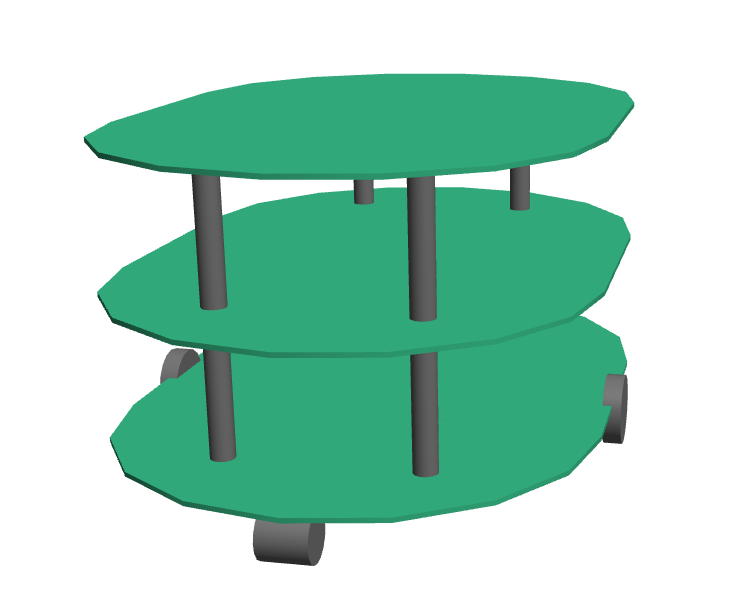

In [ ]:
import sys
!{sys.executable} -m pip install transforms3d

In [27]:
# Your code
import rclpy
from rclpy.node import Node
from visualization_msgs.msg import Marker
import geometry_msgs.msg
import std_msgs.msg
import tf_transformations as tf
from tf_transformations import quaternion_from_euler  # Add this import at the top
import math

rclpy.init()
#rclpy.init('turtle_marker_exercise')

In [ ]:
class Turtle(Node):
    def __init__(self, name, id_seed):
        super().__init__(name)
        self.publisher_ = self.create_publisher(Marker, f'/{name}_marker', 10)
        self.frame_id = name
        self.id_counter = id_seed
        self.markers = []

        self.base_offset_x = 0.0
        self.base_offset_y = 0.0
        self.base_offset_z = 0.5

        # Platforms
        for i in range(3):
            z = 0.0 + i * 0.15
            self.markers.append(self.make_cylinder(0.0, 0.0, z, 0.4, 0.4, 0.02, 0.0, 1.0, 0.0))

        # Pillars
        for level in range(2):
            z = 0.075 + level * 0.15
            for angle in [0, math.pi/2, math.pi, 3*math.pi/2]:
                x = 0.15 * math.cos(angle)
                y = 0.15 * math.sin(angle)
                self.markers.append(self.make_cylinder(x, y, z, 0.02, 0.02, 0.15, 0.3, 0.3, 0.3))

        # Wheels
        wheel_z = -0.05
        for x, y in [(0.15, 0.15), (-0.15, 0.15), (0.15, -0.15), (-0.15, -0.15)]:
            wheel = self.make_cylinder(x, y, wheel_z, 0.05, 0.02, 0.05, 0.2, 0.2, 0.2)
            wheel.pose.orientation.x = 0.0
            wheel.pose.orientation.y = 0.707
            wheel.pose.orientation.z = 0.0
            wheel.pose.orientation.w = 0.707
            self.markers.append(wheel)

        # Periodic publish
        self.timer = self.create_timer(0.5, self.publish_turtle)

    def make_cylinder(self, x, y, z, sx, sy, sz, r, g, b):
        marker = Marker()
        marker.header.frame_id = self.frame_id
        marker.type = Marker.CYLINDER
        marker.id = self.id_counter
        self.id_counter += 1
        marker.action = Marker.ADD

        marker.pose.position.x = self.base_offset_x + x
        marker.pose.position.y = self.base_offset_y + y
        marker.pose.position.z = self.base_offset_z + z

        marker.scale.x = sx
        marker.scale.y = sy
        marker.scale.z = sz

        marker.color.r = r
        marker.color.g = g
        marker.color.b = b
        marker.color.a = 0.5
        return marker

    def publish_turtle(self):
        now = self.get_clock().now().to_msg()
        for marker in self.markers:
            marker.header.stamp = now
            self.publisher_.publish(marker)


def main():
    turtle = Turtle("turtle1", 100)
    rclpy.spin(turtle)
    turtle.destroy_node()
    rclpy.shutdown()


if __name__ == '__main__':
    main()


In [29]:
rclpy.shutdown()

## Task 3

Make a marker for turtle1 and turtle2 and let them follow the position of their respective turtles continuously.

In [30]:
import rclpy
from rclpy.node import Node
from turtlesim.msg import Pose
from visualization_msgs.msg import Marker, MarkerArray
from geometry_msgs.msg import Quaternion
import math

In [ ]:
class Turtle3DMarkerPublisher(Node):
    def __init__(self):
        super().__init__('task3_turtle_marker_node')

        self.publisher = self.create_publisher(MarkerArray, 'visualization_marker_array', 10)
        self.turtle1_pose = None
        self.turtle2_pose = None

        self.create_subscription(Pose, '/turtle1/pose', self.turtle1_callback, 10)
        self.create_subscription(Pose, '/turtle2/pose', self.turtle2_callback, 10)

        self.timer = self.create_timer(0.1, self.publish_markers)

    def turtle1_callback(self, msg):
        self.turtle1_pose = msg

    def turtle2_callback(self, msg):
        self.turtle2_pose = msg

    def euler_to_quaternion(self, roll, pitch, yaw):
        qx = math.sin(roll/2) * math.cos(pitch/2) * math.cos(yaw/2) - math.cos(roll/2) * math.sin(pitch/2) * math.sin(yaw/2)
        qy = math.cos(roll/2) * math.sin(pitch/2) * math.cos(yaw/2) + math.sin(roll/2) * math.cos(pitch/2) * math.sin(yaw/2)
        qz = math.cos(roll/2) * math.cos(pitch/2) * math.sin(yaw/2) - math.sin(roll/2) * math.sin(pitch/2) * math.cos(yaw/2)
        qw = math.cos(roll/2) * math.cos(pitch/2) * math.cos(yaw/2) + math.sin(roll/2) * math.sin(pitch/2) * math.sin(yaw/2)
        return Quaternion(x=qx, y=qy, z=qz, w=qw)

    def make_marker(self, marker_type, id, ns, px, py, pz, sx, sy, sz, r, g, b, orientation=None):
        marker = Marker()
        marker.header.frame_id = "world"
        marker.id = id
        marker.ns = ns
        marker.type = marker_type
        marker.action = Marker.ADD
        marker.pose.position.x = px
        marker.pose.position.y = py
        marker.pose.position.z = pz
        marker.scale.x = sx
        marker.scale.y = sy
        marker.scale.z = sz
        marker.color.r = r
        marker.color.g = g
        marker.color.b = b
        marker.color.a = 0.8
        marker.lifetime.sec = 0
        marker.pose.orientation = orientation or Quaternion(x=0.0, y=0.0, z=0.0, w=1.0)
        return marker

    def create_turtle_markers(self, pose, ns, id_start, base_color, balloon_color):
        if pose is None:
            return []

        markers = []
        x, y, theta = pose.x, pose.y, pose.theta
        base_z = 0.5
        id_counter = id_start
        q_yaw = self.euler_to_quaternion(0, 0, theta)
        q_wheel = self.euler_to_quaternion(0, math.pi/2, 0)

        # Platforms (3 levels)
        for i in range(3):
            z = base_z + i * 0.15
            markers.append(
                self.make_marker(
                    Marker.CYLINDER, id_counter, ns,
                    x, y, z,
                    0.4, 0.4, 0.02,
                    *base_color['platform'],
                    orientation=q_yaw
                )
            )
            id_counter += 1

        # Pillars (8 at 4 corners, 2 heights)
        for level in range(2):
            z = base_z + 0.075 + level * 0.15
            for angle in [0, math.pi/2, math.pi, 3*math.pi/2]:
                px = x + 0.15 * math.cos(theta + angle)
                py = y + 0.15 * math.sin(theta + angle)
                markers.append(
                    self.make_marker(
                        Marker.CYLINDER, id_counter, ns,
                        px, py, z,
                        0.02, 0.02, 0.15,
                        *base_color['pillar'],
                        orientation=q_yaw
                    )
                )
                id_counter += 1

        # Wheels (4 on base, horizontal)
        wheel_z = base_z - 0.05
        for dx, dy in [(0.15, 0.15), (-0.15, 0.15), (0.15, -0.15), (-0.15, -0.15)]:
            wx = x + dx * math.cos(theta) - dy * math.sin(theta)
            wy = y + dx * math.sin(theta) + dy * math.cos(theta)
            markers.append(
                self.make_marker(
                    Marker.CYLINDER, id_counter, ns,
                    wx, wy, wheel_z,
                    0.05, 0.02, 0.05,
                    *base_color['wheel'],
                    orientation=q_wheel
                )
            )
            id_counter += 1

        # Balloon
        balloon_z = base_z + 0.6
        markers.append(
            self.make_marker(
                Marker.SPHERE, id_counter, ns,
                x, y, balloon_z,
                0.2, 0.2, 0.2,
                *balloon_color,
                orientation=q_yaw
            )
        )

        return markers

    def publish_markers(self):
        marker_array = MarkerArray()

        # Turtle1 with green base, gray pillars, black wheels, magenta balloon
        marker_array.markers += self.create_turtle_markers(
            self.turtle1_pose, 'turtle1', 100,
            base_color={
                'platform': (0.0, 1.0, 0.0),
                'pillar': (0.3, 0.3, 0.3),
                'wheel': (0.2, 0.2, 0.2)
            },
            balloon_color=(1.0, 0.0, 1.0)
        )

        # Turtle2 with blue base, white pillars, black wheels, aqua balloon
        marker_array.markers += self.create_turtle_markers(
            self.turtle2_pose, 'turtle2', 200,
            base_color={
                'platform': (0.0, 0.0, 1.0),
                'pillar': (1.0, 1.0, 1.0),
                'wheel': (0.1, 0.1, 0.1)
            },
            balloon_color=(0.0, 1.0, 0.7)
        )

        self.publisher.publish(marker_array)


def main(args=None):
    rclpy.init(args=args)
    node = Turtle3DMarkerPublisher()
    rclpy.spin(node)
    node.destroy_node()
    rclpy.shutdown()


if __name__ == '__main__':
    main()
